## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [12]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [2]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [3]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [4]:
print len(list(gene_exp_tumor_df.columns))-2
print len(list(gene_exp_normal_df.columns))-2

# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

515
59
gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [5]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([mirna_tumor, mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = mirna_tumor.shape[0]
n_normal = mirna_normal.shape[0]

# Drop categorical columns
mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

print "mirna_tumor", mirna_tumor.shape, 'nulls:', mirna_tumor.isnull().sum().sum()
print "gene_exp_tumor", gene_exp_tumor.shape, 'nulls:', gene_exp_tumor.isnull().sum().sum()
print "mirna_normal", mirna_normal.shape, 'nulls:', mirna_normal.isnull().sum().sum()
print "gene_exp_normal", gene_exp_normal.shape, 'nulls:', gene_exp_normal.isnull().sum().sum()

NaN            7
Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


mirna_tumor (503, 1881) nulls: 0
gene_exp_tumor (503, 20502) nulls: 0
mirna_normal (20, 1881) nulls: 0
gene_exp_normal (20, 20502) nulls: 0


## Univariate feature selection via FDR

In [7]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
mirna_filter = SelectFdr(f_classif, alpha=0.01)
mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

(523, 335)
(523, 4288)


## Build miRNA-target relationship network to identify 
## Xu et al. (xu2011prioritizing)

In [13]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet

import networkx as nx

network = miRNATargetNet(threshold=0.9)
network.train(miRNAs_A=mirna_tumor, targets_A=gene_exp_tumor, miRNAs_B=mirna_normal, targets_B=gene_exp_normal, putative_assocs=targetScan_df)
# print nx.bipartite.sets(network.B)

n_A 503
n_B 20
MiRBase ID
Gene Symbol


0
0
edges 0


/opt/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0

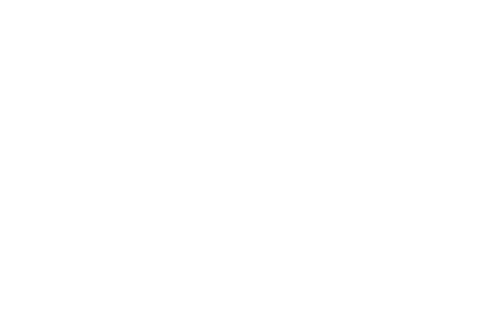

In [9]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(miRNAs_nodes))  # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(targets_nodes))  # put nodes from Y at x=2
nx.draw(network.B, pos=pos)
plt.figure(figsize=(10, 100))
plt.show()

## Loading TargetScan database for predicted miRNA-targets interactions

In [10]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]

,MiRBase ID,Gene Symbol
0,hsa-mir-23a,A1BG
1,hsa-mir-23b,A1BG
2,hsa-mir-23c,A1BG
3,hsa-mir-130a,A1BG
4,hsa-mir-23a,AAGAB
5,hsa-mir-23b,AAGAB
6,hsa-mir-23c,AAGAB
7,hsa-mir-130a,AAGAB
8,hsa-mir-23a,ABCA1
9,hsa-mir-23b,ABCA1


## Loading DIANA-TarBase database for experimentally validated miRNA-targets interactions

In [12]:
# Load data frame from file
tarBase_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TarBase_Experiment_Valid_miRNA-Targets.csv'), delimiter='\t')

# # Select only homo sapiens miRNA-target pairs
tarBase_df = tarBase_df[tarBase_df["species"] == "Homo sapiens"]
tarBase_df = tarBase_df[tarBase_df["positive_negative"] == "NEGATIVE"]
tarBase_df = tarBase_df[tarBase_df["condition"] == "NEGATIVE"]
# tarBase_df = tarBase_df[["miRNA_mature_ID", "Target gene_name"]]
# 
# # Standardize miRNA and gene symbols
# tarBase_df['miRNA_mature_ID'] = tarBase_df['miRNA_mature_ID'].str.lower()
# tarBase_df['miRNA_mature_ID'] = tarBase_df['miRNA_mature_ID'].str.replace('*', '')
# tarBase_df['Target gene_name'] = tarBase_df['Target gene_name'].str.upper()
# 
# # Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets 
# tarBase_df = tarBase_df[tarBase_df["miRNA_mature_ID"].isin(mirna_list) &
#                             tarBase_df["Target gene_name"].isin(gene_symbols)]
print tarBase_df.columns
tarBase_df

Index([u'geneId', u'geneName', u'mirna', u'species', u'cell_line', u'tissue',
       u'category', u'method', u'positive_negative', u'direct_indirect',
       u'up_down', u'condition'],
      dtype='object')


,geneId,geneName,mirna,species,cell_line,tissue,category,method,positive_negative,direct_indirect,up_down,condition
232,ALK7,ALK7,hsa-miR-376c-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,DOWN,NaN
359,Bcl-xL,Bcl-xL,hsa-miR-122-5p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,NaN,NaN
360,Bcl-xL,Bcl-xL,hsa-miR-122-5p,Homo sapiens,NaN,NaN,NaN,Western Blot,NEGATIVE,INDIRECT,NaN,NaN
433,C12ORF31,C12ORF31,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,Microarrays,NEGATIVE,INDIRECT,DOWN,NaN
469,C18orf37,C18orf37,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
477,C20ORF77,C20ORF77,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
525,C9ORF19,C9ORF19,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
579,c-met,c-met,hsa-miR-23b-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,DOWN,NaN
588,c-MYC,c-MYC,hsa-let-7g-5p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,NaN,NaN
707,E-cadherin,E-cadherin,hsa-miR-200c-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,UP,NaN


In [20]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

ELMSAN1 hsa-mir-133b
ITM2A hsa-mir-1293
hsa-mir-1238 CD101
hsa-mir-1238 CCDC141
DNAJC27 hsa-mir-133b
MAFF hsa-mir-133b
UQCC3 hsa-mir-1293
ANO2 hsa-mir-133a-2
NFKBIZ hsa-mir-133b
hsa-mir-133a-2 WFIKKN2
hsa-mir-1246 CACNA1S
hsa-mir-133b KDM6B
hsa-mir-133b CDC7
hsa-mir-1181 CACNA1S
hsa-mir-1293 PDCD6
hsa-mir-1293 MRPL21
hsa-mir-1293 ACTL6A
0.0


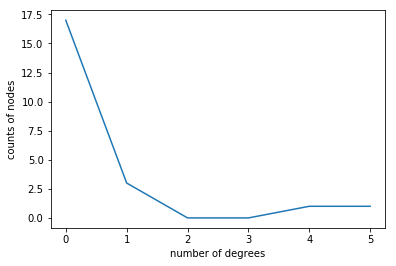

In [11]:
plt.plot(nx.degree_histogram(network.B)[1:])
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()